# Generate training data

Here the training data for the neural descriptor is extracted

In [ ]:
get_ipython().magic('run util_notebook.py')
get_ipython().magic('run -i geometry.py')

In [ ]:
get_ipython().magic('run -i config.py')
get_ipython().magic('run -i datasets.py')
get_ipython().magic('run -i planes.py')

In [ ]:
get_ipython().magic('run -i keypoint_projection.py')
get_ipython().magic('run -i patches.py')
get_ipython().magic('run -i detectors.py')

In [ ]:
loop = partial(parallel_process, threading=False, disp_progress=False)
get_ipython().magic('run -i generation.py')

In [ ]:
DIR_GEN_OUT = pp(DIR_DATASETS, 'generated')

## Syntheic

In [ ]:
# Synthetic : discover

dsets_synth = discover_synthetic_dsets(CFG_BASE)
DIR_OUT_SYNTH = pp(DIR_GEN_OUT, 'synthetic')
dsets_synth_train = dsets_synth[:50]


In [ ]:
# Synthetic : extract

gen_patches_main(
	dsets_synth_train[:50], # scenes from which to extract
	DIR_OUT_SYNTH, # output dir
	# types of patches (each creates a separate sub-dir)
	plist_ids = ['flat', 'unwarp', 'unwarp_det'],
	# filter keypoint tracks that have at least this many frames
	min_track_length = 3, 
	seq_per_dset = 1, # number of sequences per scene
	frames_per_seq = 16, # number of frames per sequence
	stride = 1, # stride in images
	proc_count = 4, # number of multiprocessing processes
)


In [ ]:
# Merge unwarp-before-detection and unwarp-after-detection patches 
# to combine them into one dataset of unwarped patches

src1_dir = pp(DIR_OUT_SYNTH, 'unwarp')
src2_dir = pp(DIR_OUT_SYNTH, 'unwarp_det')
dest_dir = pp(DIR_OUT_SYNTH, 'unwarp_both')
os.makedirs(dest_dir, exist_ok=True)

for sc_filename_unw in os.listdir(src1_dir):
	print(sc_filename_unw)
	src_file_1 = pp(src1_dir, sc_filename_unw)
	src_file_2 = pp(src2_dir, sc_filename_unw)
	dest_file = pp(dest_dir, sc_filename_unw)
	merge_patch_files((src_file_1, src_file_2), dest_file)
	


Scene: scene_001 
Extraction method: flat
Track count: 1078
Average track length: 9.55844155844
Patch count: 10304


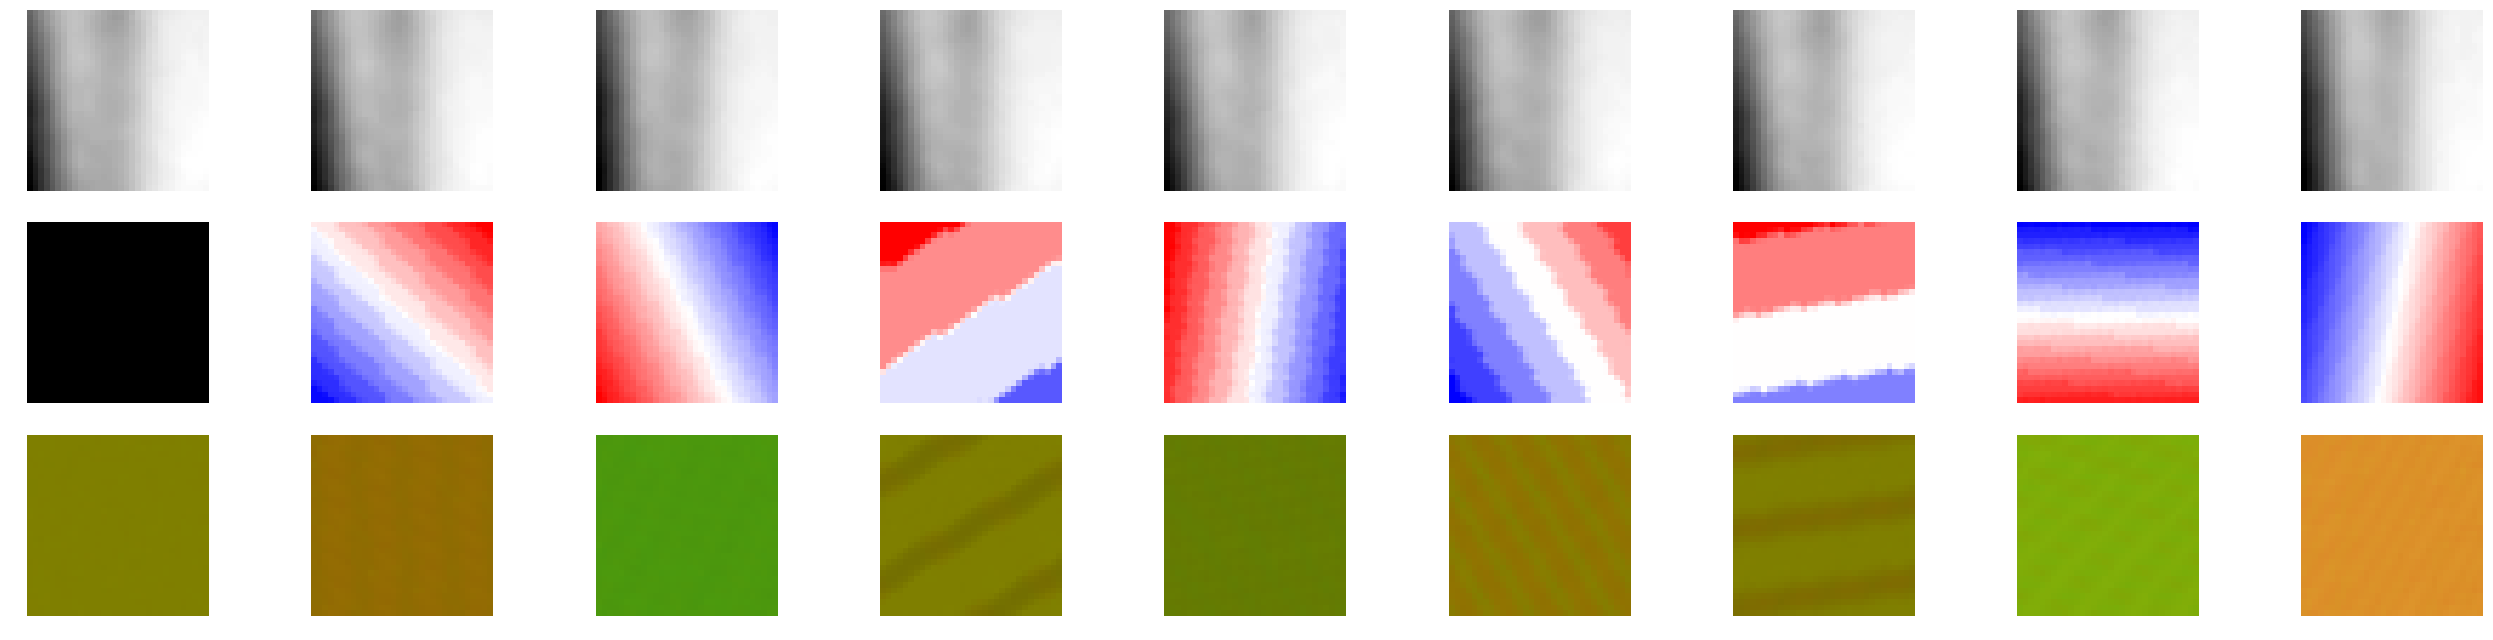

In [29]:
show_patch_file(pp(DIR_OUT_SYNTH, 'flat', 'scene_001_.hdf5'), trid=25)

## 7 Scenes

In [ ]:
# 7 SCENES : discover

dsets_7sc = discover_7scenes(CFG_BASE, 
	scenes_train=['pumpkin', 'office', 'stairs', 'chess'],
	scenes_test=['fire', 'redkitchen', 'heads'],
)

DIR_OUT_7SC = pp(DIR_GEN_OUT, '7sc')
DIR_OUT_7SC_INTERMEDIATE = pp(DIR_OUT_7SC, 'intermediate')


In [ ]:
# 7 SCENES : extract intermediate patch files
# In 7 Scenes, the same scene has several sets of images.
# Here we extract patches from each set of images, 
# in the next step we will merge those sets to produce 1 file per scene

gen_patches_main(
	dsets_7sc['train'],
	DIR_OUT_7SC_INTERMEDIATE, 
	plist_ids = ['flat', 'unwarp', 'unwarp_det'],
	min_track_length = 3,
	seq_per_dset = 16,
	frames_per_seq = 16,
	stride = 2,
	proc_count = 3,
)


In [ ]:
# Merge image sets to obtain 1 file per scene (and patch type)

def find_scene_files_in_dir(sc_name, from_dir):
	merge_regexp = pp(from_dir, sc_name + '*')
	merge_paths = glob.glob(merge_regexp)
	merge_paths.sort()
	return merge_paths

for sc in ['chess', 'office', 'pumpkin', 'stairs']:
	flat = find_scene_files_in_dir(sc, pp(DIR_OUT_7SC_INTERMEDIATE, 'flat'))
	merge_patch_files(flat, pp(DIR_OUT_7SC, 'flat', sc + '.hdf5'))
	
	unw = (
		find_scene_files_in_dir(sc, pp(DIR_OUT_7SC_INTERMEDIATE, 'unwarp'))
		+ 
		find_scene_files_in_dir(sc, pp(DIR_OUT_7SC_INTERMEDIATE, 'unwarp_det'))
	)
	merge_patch_files(unw, pp(DIR_OUT_7SC, 'unwarp', sc + '.hdf5'))

Scene: chess 0
Extraction method: flat
Track count: 17392
Average track length: 6.70825666973
Patch count: 116670


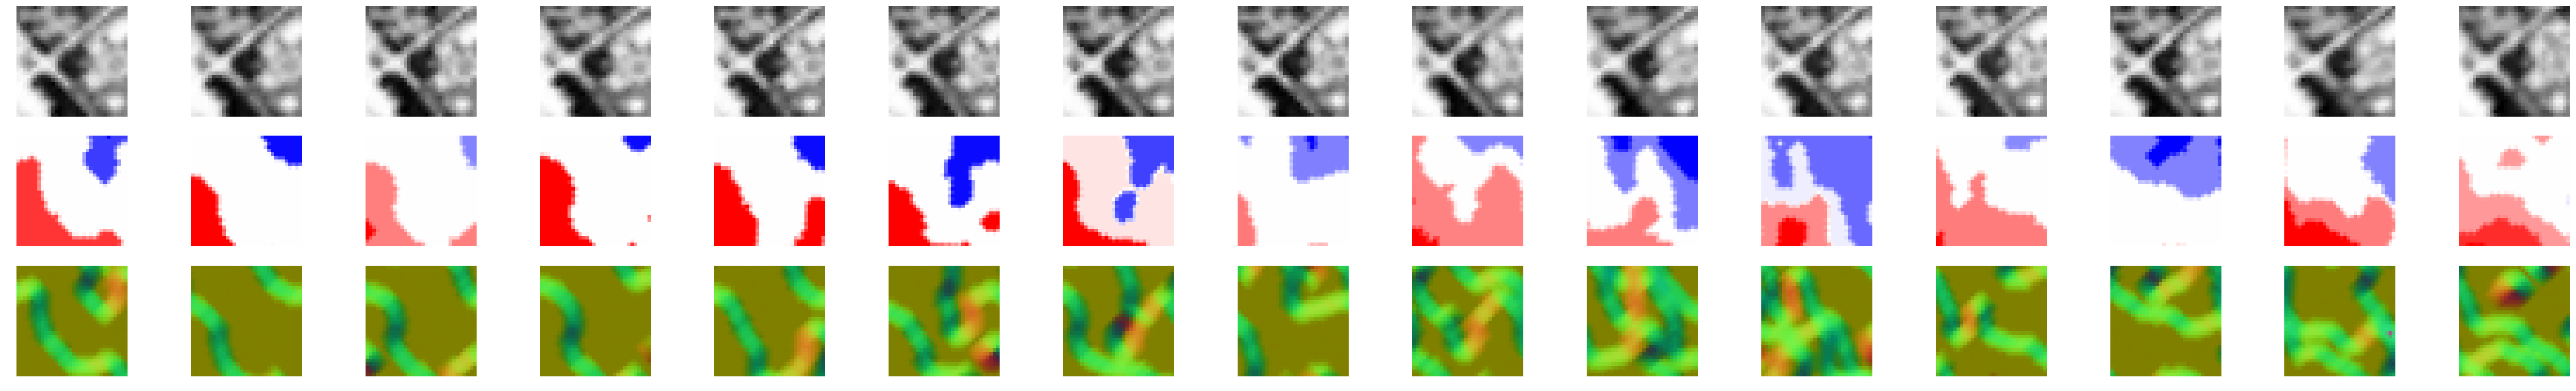

In [30]:
show_patch_file(pp(DIR_OUT_7SC, 'flat', 'chess.hdf5'), trid=25)

## Architectural

In [ ]:
# arch
dsets_arch_test = [
	DatasetSouthBuilding(CFG_BASE),
	DatasetPersonHall(CFG_BASE),
]
dsets_arch_train = [
	DatasetGerrardHall(CFG_BASE),
	DatasetGrahamHall(CFG_BASE),
]

DIR_OUT_ARCH = pp(DIR_GEN_OUT, 'arch')

In [ ]:
gen_patches_main(
	dsets_arch_train,
	DIR_OUT_ARCH,
	plist_ids = ['flat', 'unwarp', 'unwarp_det'],
	min_track_length = 2,
	seq_per_dset = 5,
	frames_per_seq = 16,
	stride = 1,
	proc_count = 1,
)

In [ ]:
src1_dir = pp(DIR_OUT_ARCH, 'unwarp')
src2_dir = pp(DIR_OUT_ARCH, 'unwarp_det')
dest_dir = pp(DIR_OUT_ARCH, 'unwarp_both')
os.makedirs(dest_dir, exist_ok=True)

for sc_filename_unw in os.listdir(src1_dir):
	print(sc_filename_unw)
	src_file_1 = pp(src1_dir, sc_filename_unw)
	src_file_2 = pp(src2_dir, sc_filename_unw)
	dest_file = pp(dest_dir, sc_filename_unw)
	merge_patch_files((src_file_1, src_file_2), dest_file)
	


Scene: gerrard-hall 0
Extraction method: flat
Track count: 2507
Average track length: 2.2138013562
Patch count: 5550


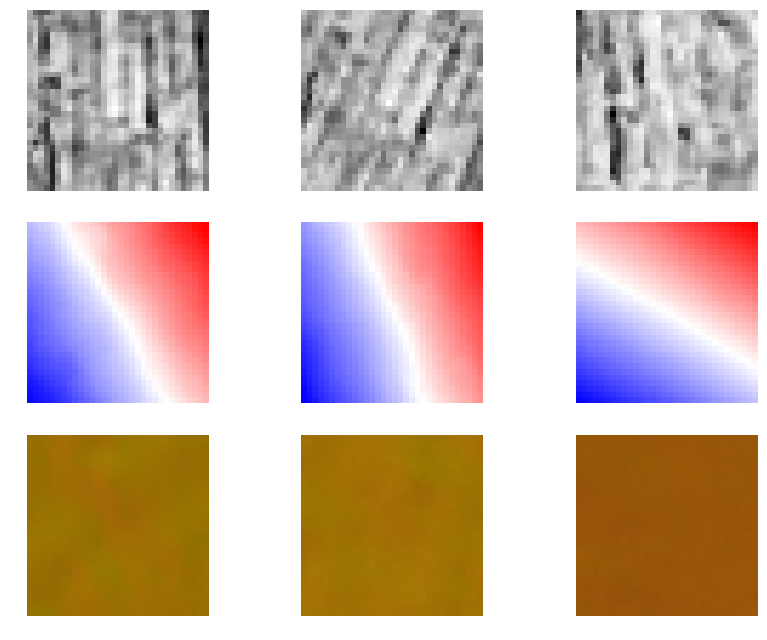

In [31]:
show_patch_file(pp(DIR_OUT_ARCH, 'flat', 'gerrard-hall_.hdf5'), trid=202)